# <font color='#48c9b0'> Using PyTorch to build a CNN for fish image classification

## <font color='#48c9b0'> Overview

This is a relatively simple personal project I set myself to get acquainted with using PyTorch and its various libraries to build a basic CNN image classifier. I arbitrarily chose a dataset off kaggle that can be accessed (as of the time of writing) [here](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/).

This dataset contains images of fish categorized into 9 distinct classes:

- Hourse Mackerel  
- Black Sea Sprat  
- Sea Bass  
- Red Mullet  
- Trout  
- Striped Red Mullet  
- Shrimp  
- Gilt-Head Bream  
- Red Sea Bream  

The objective of this project is to be able to classify images of fish into one of these categories. That being said, as mentioned prior, this is primarily an exercise to familiarize myself with using PyTorch for basic CV applications and perhaps for my own future reference. 

NOTE: Since this is mostly for my personal use, I've slapped together some pretty barebones description/commenting so apologies if anyone else is reading this :)

### <font color='#48c9b0'> Imports

In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## <font color='#48c9b0'> Load Data

In [2]:
# ### EXAMPLE DOWNLOADING DIRECTLY FROM KAGGLE ###
# import kagglehub
# path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

# print("Path to dataset files:", path)

In [3]:
fish_direc = Path(os.path.join(os.getcwd(), *["fish", "Fish_Dataset"]))
filepaths = list(fish_direc.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels').astype(str)

fish_df = pd.merge(filepaths, labels, right_index=True, left_index=True)

fish_df = fish_df[fish_df['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Alternative style of storing filepaths commented out below...
# fish_df['Filepaths'] = fish_df['Filepaths'].apply(
#     lambda x: os.path.join(*os.path.normpath(x).split(os.sep)[-2:])
# )

fish_df = fish_df.sample(frac=1).reset_index(drop=True)


## <font color='#48c9b0'> Preprocessing and Exploring the Data

In [4]:
encoding={
    'Red Sea Bream': 0,
    'Striped Red Mullet': 1,
    'Black Sea Sprat': 2,
    'Shrimp': 3,
    'Gilt-Head Bream': 4,
    'Sea Bass': 5,
    'Red Mullet': 6,
    'Hourse Mackerel': 7,
    'Trout': 8,
 }

fish_df['enc_label'] = fish_df['Labels'].map(encoding)
fish_df['enc_label'] = fish_df['enc_label'].astype(int)

fish_df.head(10)

,Filepaths,Labels,enc_label
0,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Hourse Mackerel,7
1,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Trout,8
2,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Trout,8
3,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Striped Red Mullet,1
4,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Red Mullet,6
5,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Black Sea Sprat,2
6,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Striped Red Mullet,1
7,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Sea Bass,5
8,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Shrimp,3
9,s:\Chungus Documents\Python Stuff\CNNs in PyTo...,Sea Bass,5


In [5]:
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  9000 non-null   object
 1   Labels     9000 non-null   object
 2   enc_label  9000 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 175.9+ KB


In [6]:
fish_df['Labels'].value_counts()

Labels
Hourse Mackerel       1000
Trout                 1000
Striped Red Mullet    1000
Red Mullet            1000
Black Sea Sprat       1000
Sea Bass              1000
Shrimp                1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Name: count, dtype: int64

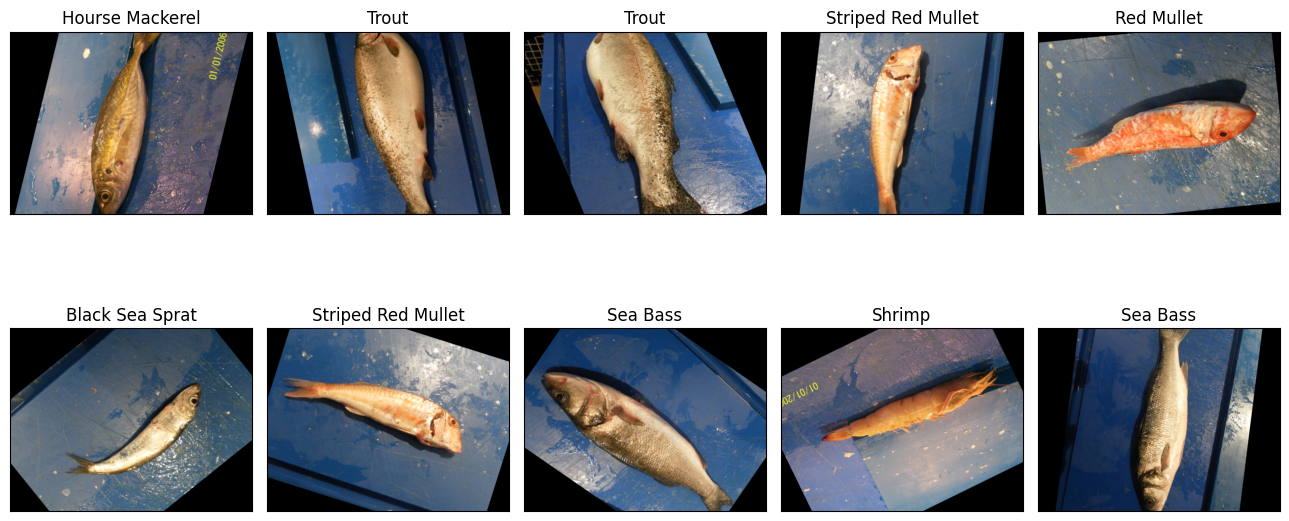

Image Tensor Shape: torch.Size([3, 445, 590])


In [7]:
## Previewing some images/checking dimensions etc...

f,a = plt.subplots(nrows=2, ncols=5,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(fish_df.Filepaths[i]))
    ax.set_title(fish_df.Labels[i])
    
plt.tight_layout()
plt.show()

example_img = Image.open(fish_df.Filepaths[0]).convert("RGB")
transform = transforms.ToTensor()
image_tensor = transform(example_img)

print("Image Tensor Shape:", image_tensor.shape)  # Format: (C, H, W)

## <font color='#48c9b0'> Creating a Custom PyTorch Dataset

In [8]:
class FishDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
        # If no transform is provided, create a basic one with resize and normalization
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet means/stds
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.dataframe.iloc[idx]["Filepaths"]
        label = self.dataframe.iloc[idx]["enc_label"]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms
        image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

## <font color='#48c9b0'> Splitting Data and Building Loaders

In [9]:
train_df, temp_df = train_test_split(fish_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f'Shape of Training Data : ', train_df.shape)
print(f'Shape of Testing Data : ', test_df.shape)
print(f'Shape of Validation Data : ', val_df.shape)

train_dataset = FishDataset(train_df)
val_dataset = FishDataset(val_df)
test_dataset = FishDataset(test_df)

batch_size = 36  # Set an appropriate batch size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Shape of Training Data :  (6300, 3)
Shape of Testing Data :  (1350, 3)
Shape of Validation Data :  (1350, 3)


In [10]:
# Sanity check our loader is working properly

data_iter = iter(train_loader)
images, labels = next(data_iter)

# # Print the shape of the batch
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: torch.Size([36, 3, 64, 64])
Shape of labels: torch.Size([36])


## <font color='#48c9b0'> Modelling

In [11]:
# FOR DIMENSION TESTING ONLY - NOT PART OF THE RESULT #

in_test = torch.randn(1, 3, 64, 64)
print(f"input tensor shape: {in_test.shape}")

conv_layer = nn.Conv2d(3, 64, 3, padding=1)
pool = nn.MaxPool2d(2,2)
conv_layer2 = nn.Conv2d(64, 64, 3, padding=1)
conv_layer3 = nn.Conv2d(64, 64, 3, padding=1)
conv_layer4 = nn.Conv2d(64, 64, 3, padding=1)
conv_layer5 = nn.Conv2d(64, 64, 3, padding=1)

out_test = pool(conv_layer(in_test))
print(f"out tensor shape (after 1 layer): {out_test.shape}")

out_test = pool(conv_layer2(out_test))
print(f"out tensor shape (after 2 layers): {out_test.shape}")

out_test = pool(conv_layer3(out_test))
print(f"out tensor shape (after 3 layers): {out_test.shape}")

# out_test = pool(conv_layer4(out_test))
# print(f"out tensor shape (after 4 layers): {out_test.shape}")

# out_test = pool(conv_layer5(out_test))
# print(f"out tensor shape (after 5 layers): {out_test.shape}")

out_test = torch.flatten(out_test, 1)
print(f"out tensor shape (after flattening): {out_test.shape}")

input tensor shape: torch.Size([1, 3, 64, 64])
out tensor shape (after 1 layer): torch.Size([1, 64, 32, 32])
out tensor shape (after 2 layers): torch.Size([1, 64, 16, 16])
out tensor shape (after 3 layers): torch.Size([1, 64, 8, 8])
out tensor shape (after flattening): torch.Size([1, 4096])


In [12]:
############################
# THIS IS THE ACTUAL MODEL #
############################

class FishModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the layers
        ## Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        
        ## FC layers
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 9)
            # NOTE: Notably we haven't applied a softmax layer here because PyTorch implements it during the loss function calc
        )
    
    def forward(self, x):
        # Forward Pass
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        out = self.fc_layers(x)        
        
        return out

# Create an instance of the model
model = FishModel()

# Print model summary
print(model)

FishModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias

In [13]:
### Set up our loss fn and optimizer...
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
### And now do the actual training loop

# Empty lists to store metrics
epoch_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    num_batches = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()
        num_batches += 1
        
        # Accuracy calc
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        current_loss = running_loss / (i + 1)
        current_acc = 100* correct / total
        progress_bar.set_postfix({'loss': f'{current_loss:.4f}', 'acc': f'{current_acc:.2f}%'})
            
    # Compute average loss for this epoch
    average_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(average_epoch_loss)
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_batches += 1
            
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {average_epoch_loss:.4f} - acc: {train_acc:.2f}% - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.2f}%")
            
            
print('Finished Training')

Epoch 1/10: 100%|██████████| 175/175 [02:42<00:00,  1.08it/s, loss=0.9978, acc=69.63%]


Epoch 1/10 - loss: 0.9978 - acc: 69.63% - val_loss: 0.6288 - val_acc: 78.59%


Epoch 2/10: 100%|██████████| 175/175 [01:33<00:00,  1.87it/s, loss=0.3347, acc=91.37%]


Epoch 2/10 - loss: 0.3347 - acc: 91.37% - val_loss: 0.2362 - val_acc: 93.41%


Epoch 3/10: 100%|██████████| 175/175 [01:34<00:00,  1.85it/s, loss=0.1943, acc=94.48%]


Epoch 3/10 - loss: 0.1943 - acc: 94.48% - val_loss: 0.1884 - val_acc: 93.85%


Epoch 4/10: 100%|██████████| 175/175 [01:36<00:00,  1.81it/s, loss=0.1250, acc=96.97%]


Epoch 4/10 - loss: 0.1250 - acc: 96.97% - val_loss: 0.0585 - val_acc: 98.81%


Epoch 5/10: 100%|██████████| 175/175 [01:34<00:00,  1.85it/s, loss=0.1018, acc=97.25%]


Epoch 5/10 - loss: 0.1018 - acc: 97.25% - val_loss: 0.0775 - val_acc: 97.93%


Epoch 6/10: 100%|██████████| 175/175 [01:36<00:00,  1.81it/s, loss=0.0806, acc=97.92%]


Epoch 6/10 - loss: 0.0806 - acc: 97.92% - val_loss: 0.0520 - val_acc: 98.74%


Epoch 7/10: 100%|██████████| 175/175 [01:34<00:00,  1.85it/s, loss=0.0793, acc=97.67%]


Epoch 7/10 - loss: 0.0793 - acc: 97.67% - val_loss: 0.0457 - val_acc: 98.96%


Epoch 8/10: 100%|██████████| 175/175 [01:34<00:00,  1.85it/s, loss=0.0651, acc=98.11%]


Epoch 8/10 - loss: 0.0651 - acc: 98.11% - val_loss: 0.0534 - val_acc: 98.89%


Epoch 9/10: 100%|██████████| 175/175 [01:36<00:00,  1.82it/s, loss=0.0595, acc=98.16%]


Epoch 9/10 - loss: 0.0595 - acc: 98.16% - val_loss: 0.0367 - val_acc: 99.04%


Epoch 10/10: 100%|██████████| 175/175 [01:35<00:00,  1.83it/s, loss=0.0526, acc=98.44%]


Epoch 10/10 - loss: 0.0526 - acc: 98.44% - val_loss: 0.0279 - val_acc: 99.19%
Finished Training


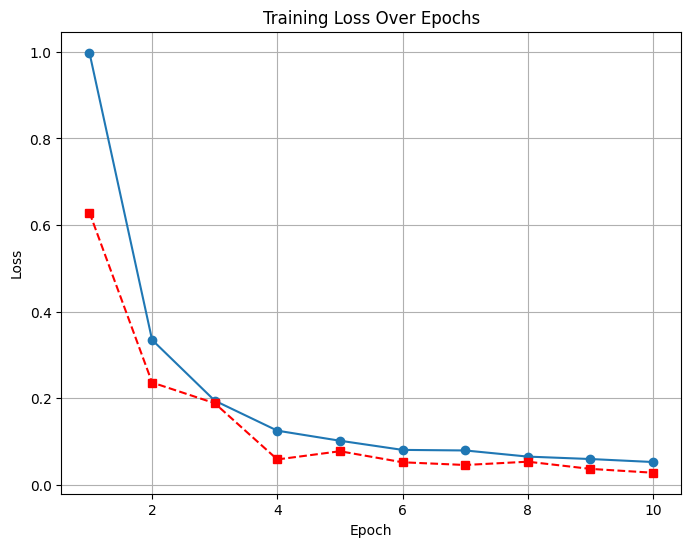

In [15]:
# Plot the loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', linestyle='--', label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

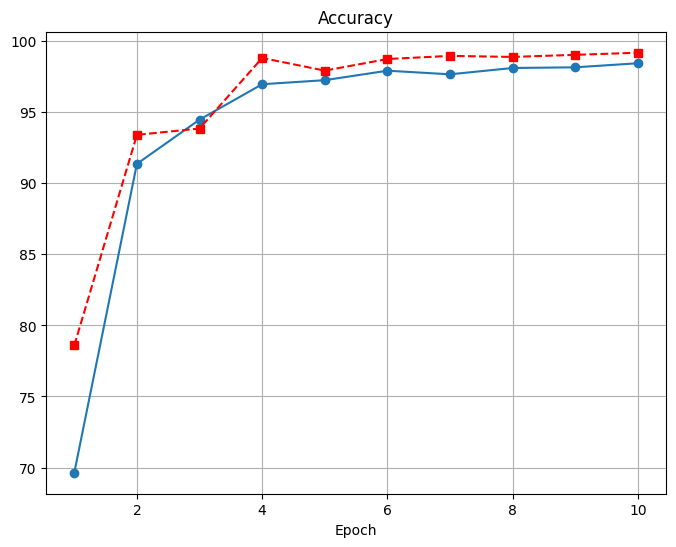

In [16]:
# Plot the accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', linestyle='--', color='red')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [ ]:
### IF WE WANT TO SAVE ###

PATH = './fish_model_10_epoch.pth'   # Edit file name as needed
# UNCOMMENT FOLLOWING LINE TO SAVE
# torch.save(model.state_dict(), PATH)

# And subsequently to reload back in...
model = FishModel()
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

## <font color='#48c9b0'> Testing the Model

In [22]:
# Just running on the test set and calculating accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


Accuracy of the network on the test images: 98.96296296296296 %
